In [1]:
import datetime as dt

import matplotlib.pyplot as plt

import pandas as pd

import pydotplus

from IPython.display import Image

from sklearn import metrics
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import export_graphviz
from sklearn.utils import resample

In [2]:
store -r

# Classification

In [3]:
# Relative monetary
relative = not_canceled.groupby(by='CustomerID', as_index=False).BasketDate.agg(['min', 'max'])

last = not_canceled['BasketDate'].max() + dt.timedelta(days=1)

relative['Days'] = relative['min'].apply(lambda x: (last - x).days)

relative = recency.merge(relative.merge(monetary.merge(frequency, on='CustomerID'), on='CustomerID'), on='CustomerID')

relative['Delta'] = (relative['max'] - relative['min']).dt.days + 1
relative['R_Monetary'] = relative['Monetary'] / relative['Delta']
relative['R_Frequency'] = relative['Frequency'] / relative['Delta']

del relative['Monetary']
del relative['Days']
del relative['Delta']
del relative['max']
del relative['min']

In [4]:
customer_profile = relative.copy()
customer_profile.head()

,CustomerID,Recency,Frequency,R_Monetary,R_Frequency
0,12346.0,326,1,77183.600000,1.000000
1,12347.0,2,7,11.775956,0.019126
2,12348.0,75,4,5.078587,0.014134
3,12349.0,19,1,1457.550000,1.000000
4,12350.0,310,1,294.400000,1.000000


<AxesSubplot:>

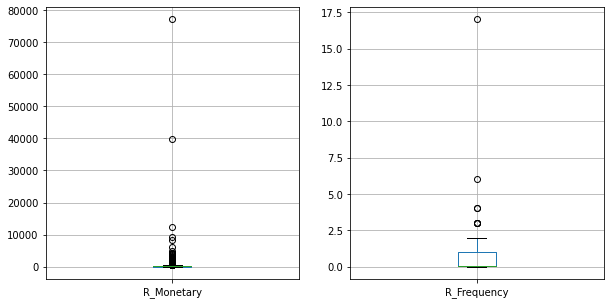

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
customer_profile.boxplot('R_Monetary', ax=ax[0])
customer_profile.boxplot('R_Frequency', ax=ax[1])

In [6]:
customer_profile.describe()

,CustomerID,Recency,Frequency,R_Monetary,R_Frequency
count,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000
mean,15299.251731,92.703046,4.245962,176.903408,0.407649
std,1721.994109,100.177047,7.634989,1380.814859,0.569770
min,12346.000000,1.000000,1.000000,0.111125,0.005464
25%,13812.250000,18.000000,1.000000,5.866700,0.020202
50%,15297.500000,51.000000,2.000000,16.643398,0.045932
75%,16778.750000,143.000000,5.000000,175.607500,1.000000
max,18287.000000,374.000000,206.000000,77183.600000,17.000000


In [7]:
ranges_m = [0.4, 0.85]
quantiles_m = customer_profile.quantile(q=ranges_m)
quantiles_m

,CustomerID,Recency,Frequency,R_Monetary,R_Frequency
0.40,14705.6,33.0,2.0,10.712782,0.03089
0.85,17394.1,218.0,7.0,311.931000,1.00000


In [8]:
ranges_f = [0.3, 0.7]
quantiles_f = customer_profile.quantile(q=ranges_f)
quantiles_f

,CustomerID,Recency,Frequency,R_Monetary,R_Frequency
0.3,14109.9,22.0,1.0,7.164762,0.023256
0.7,16480.2,109.0,4.0,132.021667,1.000000


In [9]:
ranges_r = [0.3, 0.66]
quantiles_r = customer_profile.quantile(q=ranges_r)
quantiles_r

,CustomerID,Recency,Frequency,R_Monetary,R_Frequency
0.30,14109.90,22.0,1.0,7.164762,0.023256
0.66,16241.78,88.0,4.0,97.993400,1.000000


In [10]:
def ScoreM(x, data, thresh):
    if x <= thresh[data][ranges_m[0]]:
        return 1
    elif x <= thresh[data][ranges_m[1]]:
        return 2
    else:
        return 3

def ScoreF(x, data, thresh):
    if x <= thresh[data][ranges_f[0]]:
        return 1
    elif x <= thresh[data][ranges_f[1]]:
        return 2
    else:
        return 3

def ScoreR(x, data, thresh):
    if x <= thresh[data][ranges_r[0]]:
        return 3
    elif x <= thresh[data][ranges_r[1]]:
        return 2
    else:
        return 1

In [11]:
customer_profile['MScore'] = customer_profile['R_Monetary'].apply(ScoreM, args=('R_Monetary', quantiles_m))
customer_profile['FScore'] = customer_profile['R_Frequency'].apply(ScoreF, args=('R_Frequency', quantiles_f))
customer_profile['RScore'] = customer_profile['Recency'].apply(ScoreR, args=('Recency', quantiles_r))
customer_profile['Score'] = (0.5 * customer_profile['MScore']
                            + 0 * customer_profile['FScore']
                            + 0.25 * customer_profile['RScore'])
customer_profile.describe()

,CustomerID,Recency,Frequency,R_Monetary,R_Frequency,MScore,FScore,RScore,Score
count,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000
mean,15299.251731,92.703046,4.245962,176.903408,0.407649,1.749885,1.712506,1.962621,1.365598
std,1721.994109,100.177047,7.634989,1380.814859,0.569770,0.698301,0.483225,0.799253,0.360009
min,12346.000000,1.000000,1.000000,0.111125,0.005464,1.000000,1.000000,1.000000,0.750000
25%,13812.250000,18.000000,1.000000,5.866700,0.020202,1.000000,1.000000,1.000000,1.000000
50%,15297.500000,51.000000,2.000000,16.643398,0.045932,2.000000,2.000000,2.000000,1.250000
75%,16778.750000,143.000000,5.000000,175.607500,1.000000,2.000000,2.000000,3.000000,1.750000
max,18287.000000,374.000000,206.000000,77183.600000,17.000000,3.000000,3.000000,3.000000,2.250000


In [12]:
ranges = [0.25, 0.8]
quantiles = customer_profile.quantile(q=ranges)
quantiles

,CustomerID,Recency,Frequency,R_Monetary,R_Frequency,MScore,FScore,RScore,Score
0.25,13812.25,18.0,1.0,5.8667,0.020202,1.0,1.0,1.0,1.00
0.80,17080.40,179.4,5.0,233.9240,1.000000,2.0,2.0,3.0,1.75


In [13]:
def Score(x, data, thresh):
    if x <= thresh[data][ranges[0]]:
        return 'Low'
    elif x <= thresh[data][ranges[1]]:
        return 'Medium'
    else:
        return 'High'

In [14]:
customer_labeled = customer_profile.copy()
customer_labeled['Label'] = customer_labeled['Score'].apply(Score, args=('Score', quantiles))
customer_labeled.head()

df_majority = customer_labeled[customer_labeled.Label=='Medium']
df_minority = customer_labeled[customer_labeled.Label=='High']
df_middle = customer_labeled[customer_labeled.Label=='Low']

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority))

# Upsample minority class
df_middle_upsampled = resample(df_middle, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority))

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled, df_middle_upsampled])
 
# Display new class counts
customer_labeled = df_upsampled
df_upsampled.Label.value_counts()

High      2909
Low       2909
Medium    2909
Name: Label, dtype: int64

In [15]:
# Function to discretize the variables
# Input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        mapping = {'High': 0, 'Medium': 1, 'Low': 2}

        # Add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [16]:
variables = ['Label']

# Discretize data, in this case only Label
customer_labeled = discretize_data(customer_labeled, variables)

# Drop the categorical variables since we don't need them anymore 
customer_labeled.drop(columns=['CustomerID', 'Label', 'RScore', 'R_Monetary', 'FScore', 'MScore', 'Score', 'Frequency'], axis=1,inplace=True)

label = customer_labeled.pop('Label_num')

scaler = StandardScaler()
customer_labeled = scaler.fit_transform(customer_labeled.values)

train_set, test_set, train_label, test_label = train_test_split(customer_labeled, label, stratify=label, test_size=0.3)
#train_set.head()

In [17]:
train_label.head()

2219    0
3981    2
2529    1
1849    1
322     0
Name: Label_num, dtype: int64

## Decision Tree

In [18]:
# Decision tree

dec_t = tree.DecisionTreeClassifier(criterion='gini', splitter='best',
                                  max_depth=4,
                                  min_samples_split=3, min_samples_leaf=10)

dec_t = dec_t.fit(train_set, train_label)

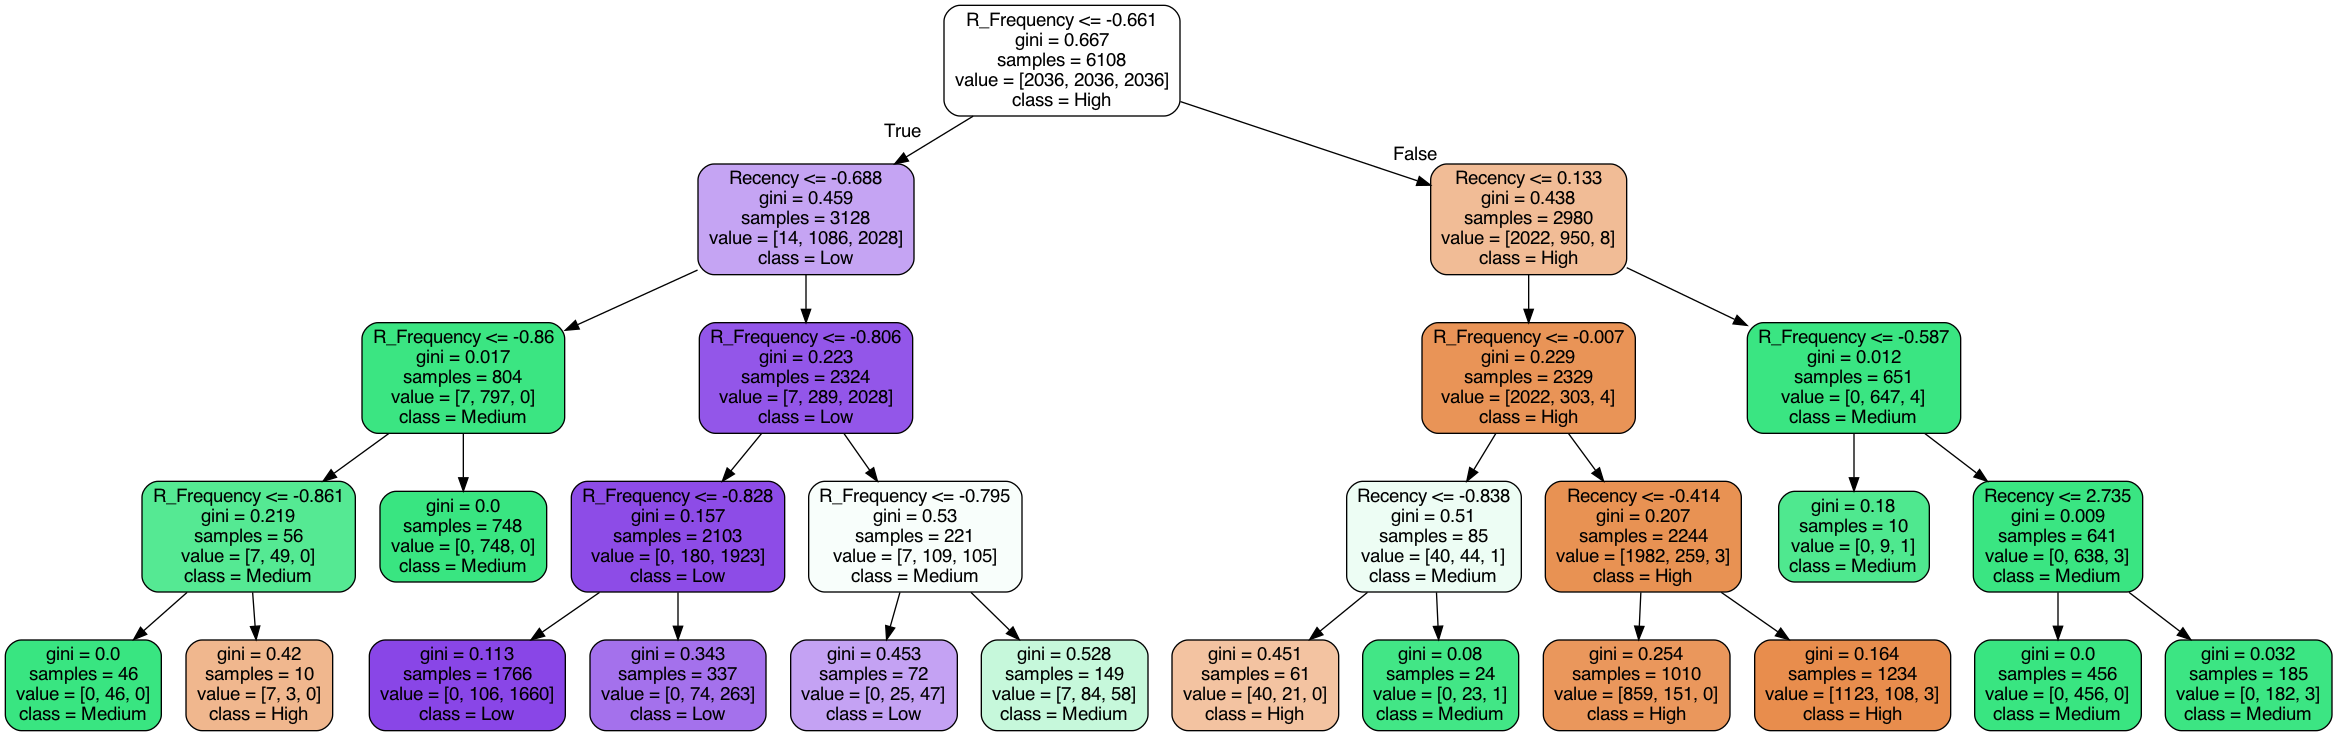

In [19]:
# Show decision tree

dot_data = tree.export_graphviz(dec_t, out_file=None,
                         feature_names=['Recency', 'R_Frequency'],
                         class_names=['High', 'Medium', 'Low'],
                         filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [20]:
# Predict phase

train_pred_dt = dec_t.predict(train_set)
test_pred_dt = dec_t.predict(test_set)

### Evaluation of the decision tree: compute accuracy, precision, recall, confusion matrix

In [21]:
# Evaulate the accuracy on the train set and the test set

print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.9081532416502947
Accuracy test set  0.9033982436044292
Precision train set  0.9129805739320744
Recall train set  0.9081532416502947
F1 score train set  0.9051981797249692
Support train set  (array([0.87645788, 0.95673671, 0.90574713]), array([0.99656189, 0.76031434, 0.9675835 ]), array([0.93265916, 0.84729064, 0.93564474]), array([2036, 2036, 2036]))


In [22]:
# metrics computed on the test set
from sklearn.metrics import classification_report
print(classification_report(test_label, 
                            test_pred_dt, 
                            target_names=['High', 'Medium','Low']))

              precision    recall  f1-score   support

        High       0.88      1.00      0.94       873
      Medium       0.95      0.75      0.84       873
         Low       0.89      0.96      0.92       873

    accuracy                           0.90      2619
   macro avg       0.91      0.90      0.90      2619
weighted avg       0.91      0.90      0.90      2619



In [23]:
# cross validation
# the score array for test/train scores on each cv split
# the time for fitting/scoring the estimator on the train set for each cv split
from sklearn.model_selection import cross_validate
import statistics 
scores = cross_validate(dec_t, train_set, train_label, cv=3, return_train_score=True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))

Fit time  0.002928018569946289
Score time  0.0006434122721354166
Test score  0.9048788474132285
Train score  0.9075802226588081


In [24]:
# compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_label, test_pred_dt)
cm

array([[870,   3,   0],
       [113, 658, 102],
       [  1,  34, 838]])

In [25]:
# compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(train_label, train_pred_dt)
cm

array([[2029,    7,    0],
       [ 283, 1548,  205],
       [   3,   63, 1970]])

## SVM

In [26]:
#linear,poly,rbf,sigmoid,precomputed
from sklearn.svm import SVC

svm = SVC(kernel='poly', C=0.5, gamma='scale')
svm.fit(train_set, train_label)

SVC(C=0.5, kernel='poly')

In [27]:
#prediction on the test test
test_pred_proba_svm = svm.predict(train_set)

In [28]:
test_pred_svm = svm.predict(test_set)

In [29]:
#compute the performance of the model
print(classification_report(test_label, 
                            test_pred_svm, 
                            target_names=['High', 'Medium', 'Low']))

              precision    recall  f1-score   support

        High       0.88      0.97      0.92       873
      Medium       0.87      0.73      0.80       873
         Low       0.87      0.92      0.90       873

    accuracy                           0.87      2619
   macro avg       0.87      0.87      0.87      2619
weighted avg       0.87      0.87      0.87      2619



In [36]:
#compute the performance of the model
print(classification_report(test_label, 
                            test_pred_svm, 
                            target_names=['High', 'Medium', 'Low']))

              precision    recall  f1-score   support

        High       0.88      0.97      0.92       873
      Medium       0.87      0.73      0.80       873
         Low       0.87      0.92      0.90       873

    accuracy                           0.87      2619
   macro avg       0.87      0.87      0.87      2619
weighted avg       0.87      0.87      0.87      2619



## KNN

In [30]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=4, algorithm='ball_tree', metric='minkowski').fit(train_set, train_label)

In [31]:
#prediction on the test test
train_pred_knn = knn.predict(train_set)

#compute the performance of the model

print(classification_report(train_label, 
                            train_pred_knn, 
                            target_names=['High', 'Medium', 'Low']))

              precision    recall  f1-score   support

        High       0.89      0.99      0.94      2036
      Medium       0.96      0.81      0.88      2036
         Low       0.93      0.97      0.95      2036

    accuracy                           0.92      6108
   macro avg       0.93      0.92      0.92      6108
weighted avg       0.93      0.92      0.92      6108



## Classification with Random Forest

In [32]:
# define and fit a random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=2,
                             max_depth=4, 
                             min_samples_split=2,
                             min_samples_leaf=8,
                             bootstrap=True) 
rf = rf.fit(train_set, train_label)

In [33]:
#prediction on the test test
train_pred_rf = rf.predict(train_set)

In [34]:
#compute the performance of the model

print(classification_report(train_label, 
                            train_pred_rf, 
                            target_names=['High', 'Medium', 'Low']))

              precision    recall  f1-score   support

        High       0.88      1.00      0.93      2036
      Medium       0.97      0.76      0.85      2036
         Low       0.90      0.97      0.94      2036

    accuracy                           0.91      6108
   macro avg       0.92      0.91      0.91      6108
weighted avg       0.92      0.91      0.91      6108

